In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import keras, os from keras.models 
import Sequential from keras.layers 
import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
train_datagen = ImageDataGenerator()
train = train_datagen.flow_from_directory(directory="the_met_objects/train", target_size=(224,224))

test_datagen = ImageDataGenerator()
test = test_datagen.flow_from_directory(directory="the_met_objects/test", target_size=(224,224))

Found 316 images belonging to 16 classes.
Found 80 images belonging to 16 classes.


---

In [4]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=16, activation="softmax"))

2021-11-11 19:32:18.472119: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [8]:


checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(generator=train, validation_data= test,\
                           epochs=20,callbacks=[checkpoint,early])


/Users/doguma/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-11 19:33:08.118131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
 1/10 [==>...........................] - ETA: 2:06 - loss: 2.5162 - accuracy: 0.4062

/Users/doguma/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (100920000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


10/10 [==============================] - 98s 9s/step - loss: 7600.1060 - accuracy: 0.4873 - val_loss: 1.1557 - val_accuracy: 0.9375
Epoch 2/20
10/10 [==============================] - 94s 9s/step - loss: 1.4334 - accuracy: 0.6899 - val_loss: 0.3869 - val_accuracy: 0.9500
Epoch 3/20
10/10 [==============================] - 96s 9s/step - loss: 1.3792 - accuracy: 0.6835 - val_loss: 0.5432 - val_accuracy: 0.9500
Epoch 4/20
10/10 [==============================] - 97s 10s/step - loss: 1.2213 - accuracy: 0.6835 - val_loss: 0.7998 - val_accuracy: 0.9500
Epoch 5/20
10/10 [==============================] - 99s 10s/step - loss: 1.1256 - accuracy: 0.6835 - val_loss: 0.5537 - val_accuracy: 0.9500
Epoch 6/20
10/10 [==============================] - 102s 10s/step - loss: 1.0468 - accuracy: 0.6835 - val_loss: 0.5380 - val_accuracy: 0.9500
Epoch 7/20
10/10 [==============================] - 103s 10s/step - loss: 1.0183 - accuracy: 0.6835 - val_loss: 0.7468 - val_accuracy: 0.9500
Epoch 8/20
10/10 [====

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, None, None, 64)    1792      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, None, None, 128)   73856     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, None, None, 256)   2

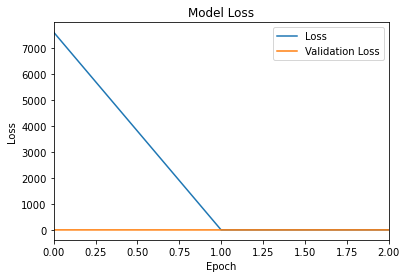

In [56]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xlim([0, 2])
plt.legend(["Loss","Validation Loss"])
plt.show()

In [59]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(generator=train, validation_data= test,\
                           epochs=5,callbacks=[checkpoint,early])

Epoch 1/5
10/10 [==============================] - 138s 14s/step - loss: 0.3986 - accuracy: 0.8703 - val_loss: 2.1783 - val_accuracy: 0.5375
Epoch 2/5
10/10 [==============================] - 168s 17s/step - loss: 0.3893 - accuracy: 0.8734 - val_loss: 1.4390 - val_accuracy: 0.5375
Epoch 3/5
10/10 [==============================] - 195s 20s/step - loss: 0.2761 - accuracy: 0.9082 - val_loss: 3.2376 - val_accuracy: 0.4500
Epoch 4/5
10/10 [==============================] - 213s 22s/step - loss: 0.2639 - accuracy: 0.9177 - val_loss: 1.8026 - val_accuracy: 0.4875
Epoch 5/5
 6/10 [=================>............] - ETA: 1:15 - loss: 0.1993 - accuracy: 0.9309WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


10/10 [==============================] - 216s 22s/step - loss: 0.2331 - accuracy: 0.9146 - val_loss: 2.8521 - val_accuracy: 0.4000


In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("VGG16 Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
# plt.xlim([0, 2])
plt.legend(["Loss","Validation Loss"])
plt.show()

In [15]:
country_list = ['afghanistan',
 'ancient-kingdom-of-kashmir',
 'burma',
 'china',
 'india',
 'indo-portuguese',
 'japan',
 'mysore-or-tamil-nadu',
 'nepal',
 'northwest-china',
 'others',
 'pakistan',
 'south-india',
 'sri-lanka',
 'thailand',
 'tibet']

In [67]:
from keras.preprocessing import image

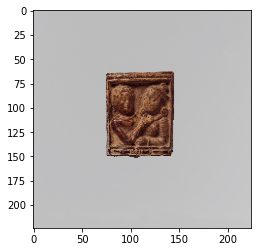

In [40]:
img = image.load_img("41900.png",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

output3 = model.predict(img)

In [41]:
country_list[list(output3[0]).index(max(list(output3[0])))]
# afghanistan - but west indian manufacture

'india'

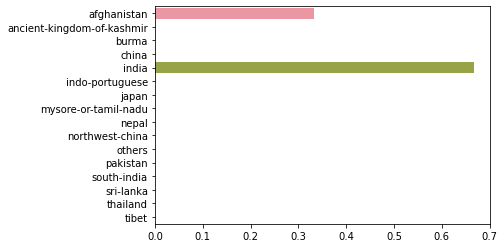

In [51]:
ax = sns.barplot(x=list(output3[0]), y=country_list)

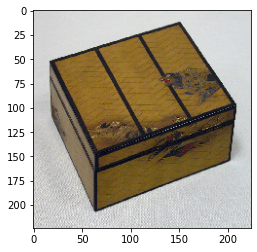

In [64]:
img = image.load_img("57978.png",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

output4 = model.predict(img)

In [65]:
country_list[list(output4[0]).index(max(list(output4[0])))]
# afghanistan - but west indian manufacture

'japan'

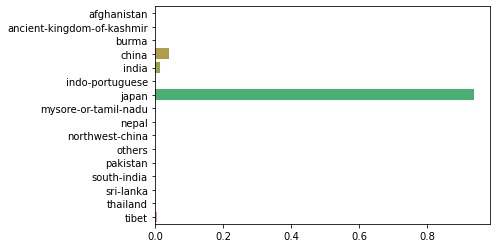

In [66]:
ax = sns.barplot(x=list(output4[0]), y=country_list)

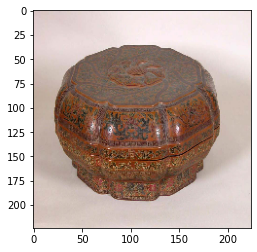

In [71]:
img = image.load_img("60915.png",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

output5 = model.predict(img)

In [72]:
country_list[list(output5[0]).index(max(list(output5[0])))]

'japan'

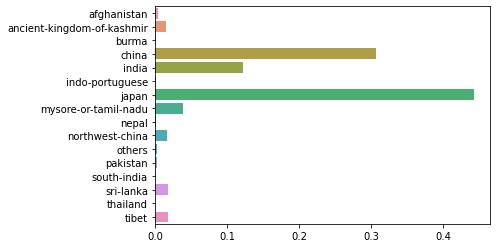

In [73]:
ax = sns.barplot(x=list(output5[0]), y=country_list)